# Machine Learning Online Class - Exercise 2: Logistic Regression

In this part of the exercise, we will implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly.

## Load Data

The first two columns contains the x values and the third column contains the label (y).

In [1]:
import numpy as np


data = np.loadtxt(open("ex2data2.txt", "r"), delimiter=",")
x = data[:, 0:2]
y = data[:, 2:3]

The `plot_data` is the same as in ex2.

In [2]:
import matplotlib.pyplot as plt


def plot_data(x, y, show=False):
    """
    Plots the data points x and y into a new figure.

    Parameters
    ----------
    x : array
        Data on x axis. It's a m by 2 matrix, where m is the number of data samples and the number of features is 2.
    y : array
        Data on y axis, m by 1 matrix.
    show : bool
        True to show the plot immediately.
    """
    plt.figure()

    pos = np.argwhere(y.flatten() == 1)
    neg = np.argwhere(y.flatten() == 0)

    plt.plot(x[pos, 0], x[pos, 1], linestyle='', marker='+', color='k')
    plt.plot(x[neg, 0], x[neg, 1], linestyle='', marker='o', color='y')

    if show:
        plt.show()

Plot the data:

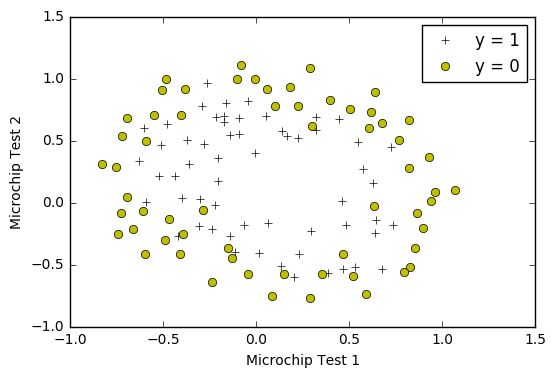

In [3]:
plot_data(x, y)
# Labels and Legend
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.legend(['y = 1', 'y = 0'], loc='upper right', numpoints=1)
plt.show()

## Part 1: Regularized Logistic Regression

The `map_feature` function below maps input features to polynomial ones.

In [4]:
def map_feature(x1, x2):
    """
    Feature mapping function to polynomial features. Inputs X1, X2 must be the same size.

    Parameters
    ----------
    x1 : ndarray
        Input feature.
    x2 : ndarray
        Input feature.

    Returns
    -------
    out : ndarray
        A new feature array with more features, comprising of X1, X2, X1.^2, X2.^2, X1*X2, X1*X2.^2, etc..
    """
    degree = 6
    out = np.ones(x1[:, 0:1].shape)

    for i in range(1, degree + 1):
        for j in range(0, i + 1):
            tmp = np.power(x1, i - j) * np.power(x2, j)
            out = np.concatenate((out, tmp), axis=1)
    return out

Add polynomial features: 

In [5]:
# Note that map_feature also adds a column of ones for us, so the intercept term is handled
x = map_feature(x[:, 0:1], x[:, 1:2])

Initialize parameters as follows: 

In [6]:
m, n = x.shape
# Initialize fitting parameters
initial_theta = np.zeros((n, 1))
# Set regularization parameter lambda to 1
l = 1

The `cost_function_reg` function below compute cost and gradient for logistic regression with regularization.

In [7]:
def sigmoid(z):
    """
    Compute sigmoid function.

    Parameters
    ----------
    z : array_like
        Variable for sigmoid function.

    Returns
    -------
    ndarray
        The sigmoid of each value of z.
    """
    g = 1 / (1 + np.exp(-z))
    return g


def cost_function_reg(theta, x, y, l):
    """
    Compute cost and gradient for logistic regression with regularization.

    Parameters
    ----------
    theta : ndarray
        Linear regression parameter, n by 1 matrix where n is the number of features.
    x : ndarray
        Training data, m by n matrix where m is the number of data samples.
    y : ndarray
        Labels, m by 1 matrix.
    l : float
        Regularization parameter.

    Returns
    -------
    J : numpy.float64
        The cost of using theta as the parameter for regularized logistic regression w.r.t. the parameters.
    grad: ndarray
        Partial derivatives of the cost w.r.t. each parameter in theta, n by 1 matrix.
    """
    (m, n) = x.shape
    theta = theta.reshape(n, 1)

    x_dot_theta = x.dot(theta)
    mask = np.eye(theta.shape[0])
    # Skip the theta[0, 0] parameter when performing regularization
    mask[0, 0] = 0

    j = 1.0 / m * (np.dot(-y.T, np.log(sigmoid(x_dot_theta))) - np.dot((1 - y).T, np.log(1 - sigmoid(x_dot_theta)))) \
        + 1.0 * l / (2 * m) * np.sum(np.power((mask.dot(theta)), 2))
    grad = 1.0 / m * np.dot((sigmoid(x_dot_theta) - y).T, x).T + 1.0 * l / m * (mask.dot(theta))

    return j, grad

Test `cost_function_reg` on inital parameters:

In [8]:
j, g = cost_function_reg(initial_theta, x, y, l)

print 'Cost at initial theta (zeros):', j

Cost at initial theta (zeros): [[ 0.69314718]]


## Part 2: Regularization and Accuracies

The `fmin_tnc` function in `scipy.optimize` requires a seperate implemention for cost and gradient function as follows: 

In [9]:
def cost_reg_opt(theta, x, y, l):
    """
    Compute cost for logistic regression with regularization.

    Parameters
    ----------
    theta : ndarray
        Linear regression parameter, n by 1 matrix where n is the number of features.
    x : ndarray
        Training data, m by n matrix where m is the number of data samples.
    y : ndarray
        Labels, m by 1 matrix.
    l : float
        Regularization parameter.

    Returns
    -------
    J : numpy.float64
        The cost of using theta as the parameter for linear regression to fit the data points in x and y.
    """
    j, g = cost_function_reg(theta, x, y, l)
    return j


def gradient_reg_opt(theta, x, y, l):
    """
    Compute gradient for logistic regression with regularization.

    Parameters
    ----------
    theta : ndarray
        Linear regression parameter, n by 1 matrix where n is the number of features.
    x : ndarray
        Training data, m by n matrix where m is the number of data samples.
    y : ndarray
        Labels, m by 1 matrix.
    l : float
        Regularization parameter.

    Returns
    -------
    grad: ndarray
        Partial derivatives of the cost w.r.t. each parameter in theta, n by 1 matrix.
    """
    j, g = cost_function_reg(theta, x, y, l)
    return g

Train the model with `fin_tnc`:

In [10]:
import scipy.optimize as opt


result = opt.fmin_tnc(func=cost_reg_opt, x0=initial_theta, fprime=gradient_reg_opt, args=(x, y, l), messages=0)
theta = result[0].T

The `plot_decision_boundary` plots the data points with the decision boundary defined by theta.

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from map_feature import map_feature


def plot_decision_boundary(theta, x, y):
    """
    Plots the data points X and y into a new figure with the decision boundary defined by theta.

    Parameters
    ----------
    theta : ndarray
        Linear regression parameter, n by 1 matrix where n is the number of features.
    x : ndarray
        Training data, m by n matrix where m is the number of data samples.
    y : ndarray
        Labels, m by 1 matrix.
    """
    if x.shape[1] <= 3:
        plot_x = np.array([np.amin(x[:, 1]) - 2, np.amax(x[:, 1]) + 2])
        plot_y = -1.0 / theta[2] * (theta[1] * plot_x + theta[0])
        print plot_x, plot_y
        plt.plot(plot_x, plot_y)
    else:
        u = np.linspace(-1, 1.5, 50)
        u.resize((len(u), 1))
        v = np.linspace(-1, 1.5, 50)
        v.resize((len(v), 1))
        z = np.zeros((len(u), len(v)))
        for i in range(len(u)):
            for j in range(len(v)):
                z[i, j] = map_feature(u[i, 0:1].reshape((1,1)), v[j, 0:1].reshape((1,1))).dot(theta)
        z = z.T
        u, v = np.meshgrid(u, v)
        cs = plt.contour(u, v, z, levels=[0])
        fmt = {}
        strs = ['Decision boundary']
        for l, s in zip(cs.levels, strs):
            fmt[l] = s

        plt.clabel(cs, cs.levels[::2], inline=True, fmt=fmt, fontsize=10)


Plot the boundary: 

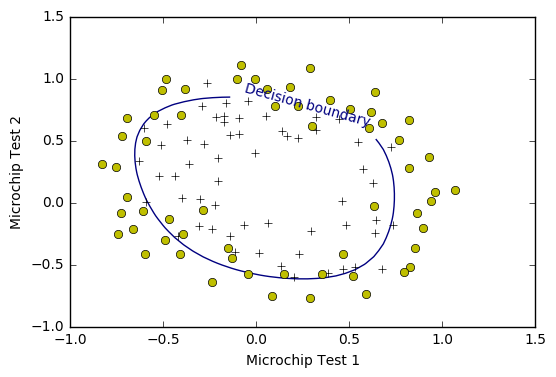

In [12]:
plot_data(x[:, 1:3], y)
plot_decision_boundary(theta, x, y)
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.show()

The `predict` function below predicts the input data with learned logistic regression parameters.

In [13]:
def predict(theta, x):
    """
    Predict whether the label is 0 or 1 using learned logistic regression parameters theta.

    Parameters
    ----------
    theta : ndarray
        Linear regression parameter, n by 1 matrix where n is the number of features.
    x : ndarray
        Training data, m by n matrix where m is the number of data samples.

    Returns
    -------
    ndarray
        The predictions for X using a threshold at 0.5, m by 1 matrix.
    """
    p = sigmoid(x.dot(theta)) >= 0.5
    p.resize(len(p), 1)
    return p.astype(int)

Compute accuracy on our training set: 

In [14]:
p = predict(theta, x)
print 'Train Accuracy:', np.mean(p == y) * 100

Train Accuracy: 83.0508474576
